In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/Dataset100KForNERWords.csv', 
                    usecols=['sentença',
                             'Palavra', 
                             'Word2idx', 
                             'classOfWords']) # importando nosso
                                              # Dataset

In [3]:
sentenças = data['sentença'].to_list()
Word2idx = data['Word2idx'].to_list()
classOfWords = data['classOfWords'].to_list()

In [4]:
# mudando as tags
# de = {'O': 0,   para = {'O': 1,     
#  'I-Cla': 1,            'I-Cla': 2,
#  'I-Seg': 2,            'I-Seg': 3,
#  'I-Jur': 3,            'I-Jur': 4,
#  'I-FiM': 4,            'I-FiM': 5,
#  'B-FiF': 5,            'B-FiF': 6,
#  'I-FiF': 6,            'I-FiF': 7,
#  'B-Jur': 7,            'B-Jur': 8,
#  'B-FiM': 8,            'B-FiM': 9,
#  'I-Gov': 9,            'I-Gov': 10,
#   'I-Ass': 10,          'I-Ass': 11,
#   'B-Gov': 11,          'B-Gov': 12,
#   'B-Ass': 12,          'B-Ass': 13,
#   'B-Cla': 13,          'B-Cla': 14,
#   'B-Seg': 14,          'B-Seg': 15,
#   'B-Val': 15,          'B-Val': 16,
#   'I-Val': 16}          'I-Val': 17}

new_classOfWords = []
for y in classOfWords:
    new_classOfWords.append(y+1)
len(new_classOfWords), len(classOfWords)

(16438905, 16438905)

In [5]:
# construindo as sentenças

i = 0
X_seq = []
Y_seq = []
unique, inicio = np.unique(sentenças,return_index=True)

for i,ind in enumerate(inicio):

    if (i != 87918):
        X_seq.append(Word2idx[ind:inicio[i+1]])
        Y_seq.append(new_classOfWords[ind:inicio[i+1]])
    else:
        X_seq.append(Word2idx[ind:])
        Y_seq.append(new_classOfWords[ind:])


In [6]:
maxs = [np.max(seq) for seq in X_seq]
np.max(maxs)

366549

In [7]:
tag2idx = {'O': 1,     
           'I-Cla': 2,
           'I-Seg': 3,
           'I-Jur': 4,
           'I-FiM': 5,
           'B-FiF': 6,
           'I-FiF': 7,
           'B-Jur': 8,
           'B-FiM': 9,
           'I-Gov': 10,
           'I-Ass': 11,
           'B-Gov': 12,
           'B-Ass': 13,
           'B-Cla': 14,
           'B-Seg': 15,
           'B-Val': 16,
           'I-Val': 17} # dicionário de tags [apenas para labels]

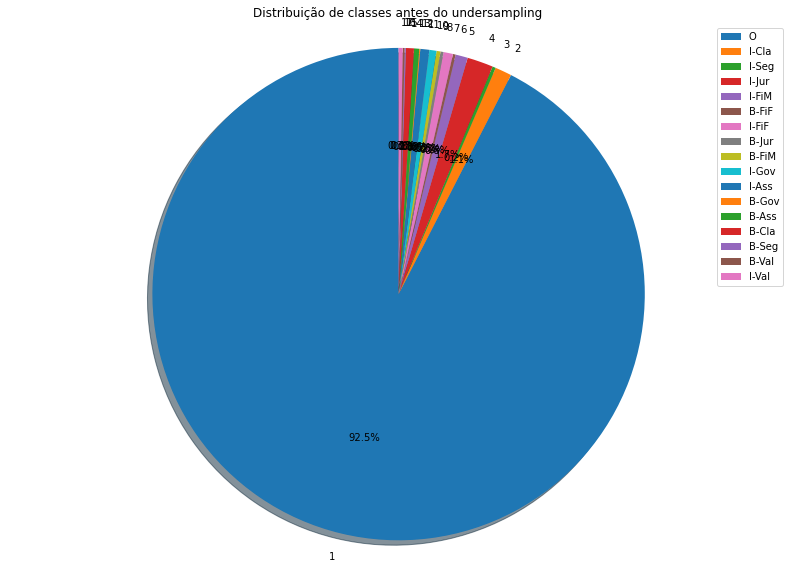

In [8]:
fig, ax1 = plt.subplots(figsize=(14, 10))
concate_Y_seq = np.asarray([element for y_seq in Y_seq for element in y_seq])
labels,sizes = np.unique(concate_Y_seq, return_counts=True)
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(list(tag2idx.keys()))
ax1.set_title('Distribuição de classes antes do undersampling')

plt.show()

In [9]:
undersampled_X_seq = [] # new list of undersampled word samples
undersampled_Y_seq = [] # new list of undersampled classes samples

In [10]:
# this function separes groups of sequences elements in a array
# exemple: data = [0,12,13,14,20,21,22] => [array(0), array(12,13,14), array(20,21,22)]
def consecutive(data, stepsize=1):
    return list(np.split(data, np.where(np.diff(data) != stepsize)[0]+1))

In [11]:
from tqdm import tqdm
from itertools import compress
Rs = 34 # desired sampling ratio

for sentence,classe in tqdm(zip(X_seq,Y_seq), total=len(X_seq)): # for sentence in dataset

    unique, counts = np.unique(classe, return_counts=True)

    Np = len(classe) - counts[0] # Number of positives tokens
    Nn = counts[0] # Number of negative tokens
    Ns = 0 # Number of selected negative tokens in sentence
    
    array_classe = np.array(classe) # just a convert type from list to numpy array
    array_sentence = np.array(sentence) # just a convert type from list to numpy array

    selected_mask = array_classe > 1 # taking the mask of all positive classes 

    if(Np != 0): # if the setence has at least a single positive tag 
        if(Nn/Np <= Rs): #if the Ratio of Negative tokens is lower then our Ratio: no need for undersampling, select all tokens
            undersampled_X_seq.append(sentence)
            undersampled_Y_seq.append(classe)
        else: 
            while (Ns/Np <= Rs):
                idx_mask = list(np.where(selected_mask == True)) # select the index where our mask is True
                idx_consecutives = consecutive(idx_mask[0]) # group a sequence of array
                # select all in the left first, after all in the right
                for entity in idx_consecutives:
                    m_left_el = np.min(entity) # most left element
                    try:
                        #selecting the most left element not selected in group
                        if(not selected_mask[m_left_el - 1]): 
                            selected_mask[m_left_el - 1] = True
                            Ns += 1
                    except:
                        pass
                for entity in idx_consecutives:
                    m_right_el = np.max(entity) # most right element
                    try:
                        #selecting the most left element not selected in group
                        if(not selected_mask[m_right_el + 1]): 
                            selected_mask[m_right_el + 1] = True
                            Ns += 1
                    except:
                        pass
         
            undersampled_Y_seq.append(list(compress(classe, selected_mask.tolist()))) # add the undersampled sample in new list
            undersampled_X_seq.append(list(compress(sentence, selected_mask.tolist()))) # add the undersampled sample in new list

100%|██████████| 87919/87919 [01:09&lt;00:00, 1258.98it/s]


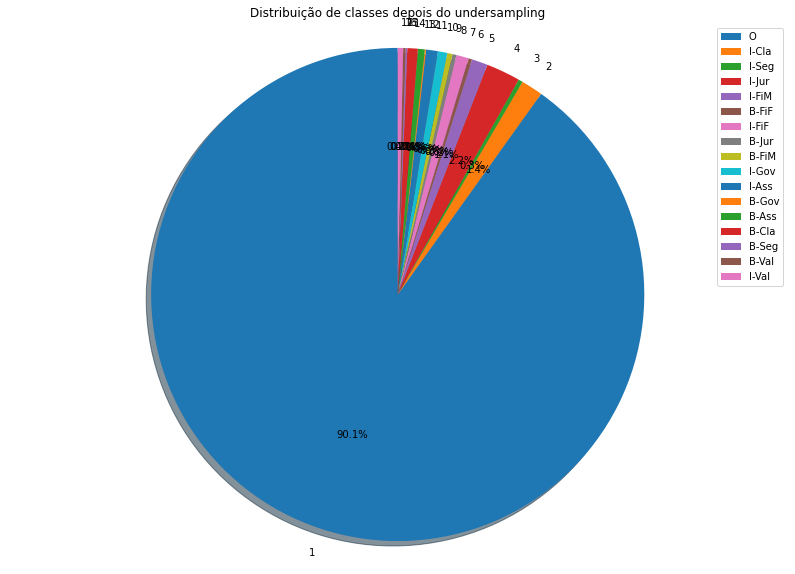

In [12]:
fig, ax1 = plt.subplots(figsize=(14, 10))
concate_Y_seq = np.asarray([element for y_seq in undersampled_Y_seq for element in y_seq])
labels,sizes = np.unique(concate_Y_seq, return_counts=True)
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(list(tag2idx.keys()))
ax1.set_title('Distribuição de classes depois do undersampling')

plt.show()

In [13]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
max_len=150

y = pad_sequences(maxlen=max_len,
                  sequences=undersampled_Y_seq,
                  padding="post",
                  truncating="post")

X = pad_sequences(maxlen=max_len,
                  sequences=undersampled_X_seq,
                  padding="post",
                  truncating="post")

y_padded = pad_sequences(maxlen=max_len,
                  sequences=Y_seq,
                  padding="post",
                  truncating="post")

X_padded = pad_sequences(maxlen=max_len,
                  sequences=X_seq,
                  padding="post",
                  truncating="post")

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional, Input, Masking

tf.__version__, tf.executing_eagerly()

(&#39;2.3.0&#39;, True)

In [17]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name=&#39;/physical_device:CPU:0&#39;, device_type=&#39;CPU&#39;),
 PhysicalDevice(name=&#39;/physical_device:XLA_CPU:0&#39;, device_type=&#39;XLA_CPU&#39;),
 PhysicalDevice(name=&#39;/physical_device:XLA_GPU:0&#39;, device_type=&#39;XLA_GPU&#39;),
 PhysicalDevice(name=&#39;/physical_device:GPU:0&#39;, device_type=&#39;GPU&#39;)]

In [18]:
X_tr_und, X_te_und, y_tr_und, y_te_und = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=123)
X_tr, X_te, y_tr, y_te = train_test_split(X_padded, y_padded, test_size=0.1, shuffle=True, random_state=123)

In [19]:
units = 512 # output da LSTM
Emb_dims = 50 # tamanho do vetor de embeddings
Spa_dropout = 0.5 # spacial dropout rate
n_tags = 18 # quantidade de tags

model = Sequential()
model.add(Input(shape=(None,)))
model.add(Embedding(input_dim=np.max(maxs) + 1, output_dim=Emb_dims, mask_zero=True))
model.add(SpatialDropout1D(Spa_dropout))
model.add(Bidirectional(LSTM(units=units, return_sequences=True), merge_mode='sum'))
model.add(Dense(n_tags, activation="softmax"))

In [20]:
### definindo metricas customizadas

def recall(y_true, y_pred):
    y_pred = tf.cast(K.argmax(y_pred), tf.float32) # transformando o vetor de (None, 150, n_tags) para (None, 150)
    macro_recall = 0
    y_pred = y_pred[y_true != 0] # retira zero
    y_true = y_true[y_true != 0] # retira zero
    equals = y_pred[K.equal(y_true,y_pred)]  # calcula os verdadeiros positivos, ignorando o zero
    
    for i in range(1,n_tags):
        equals_positives = equals[equals == i]  
        true_positives = K.sum(equals_positives/i) # divide por i, para que os valores se tornem 1

        equals_possibles = y_true[K.equal(y_true,K.constant(i))]/i
        possible_positives = K.sum(equals_possibles)

        recall = true_positives / (possible_positives + K.epsilon())
        macro_recall = macro_recall + recall

    macro_recall = macro_recall/(n_tags-1)  

    return macro_recall

def precision(y_true, y_pred):
    y_pred = tf.cast(K.argmax(y_pred), tf.float32) # trannsformando o vetor de (None, 150, n_tags) para (None, 150)
    macro_precision = 0
    y_pred = y_pred[y_true != 0] # retira zero
    y_true = y_true[y_true != 0] # retira zero
    equals = y_true[K.equal(y_true,y_pred)]  # calcula os verdadeiros positivos, ignorando o zero
    
    for i in range(1,n_tags):
        equals_positives = equals[equals == i]  
        true_positives = K.sum(equals_positives/i) # divide por i, para que os valores se tornem 1

        equals_pred_possibles = y_pred[K.equal(y_pred,K.constant(i))]/i
        predicted_positives = K.sum(equals_pred_possibles)

        precision = true_positives / (predicted_positives + K.epsilon())
        macro_precision = macro_precision + precision

    macro_precision = macro_precision/(n_tags-1)

    return macro_precision

def macro_f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [21]:
model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["SparseCategoricalAccuracy",
              recall,
              precision,
              macro_f1])

In [22]:
print('antes:',len(X_seq),'depois:',len(undersampled_X_seq), '\n')
print('antes:',len(X_seq[0]),'depois:',len(undersampled_X_seq[0]), '\n')
print('antes:',np.asarray(X_seq[0]),'antes:',np.asarray(Y_seq[0]), '\n')
print('depois:',np.asarray(undersampled_X_seq[0]),'depois:',np.asarray(undersampled_Y_seq[0]), '\n')
print()
print('-'*100, '\n')
print('antes:',np.asarray(X_padded[0]),'antes:',np.asarray(y_padded[0]), '\n')
print('depois:',np.asarray(X[0]),'depois:',np.asarray(y[0]))


antes: 87919 depois: 87860 

antes: 61 depois: 61 

antes: [    16  45585    417     59     15     17   2506   8342    538    610
  45586     44    231  21360     30  21005  21361  24630   1472     25
    260 120686   1547   1787     25    260   3210   1787     25    260
   1757      3    230    638     42   4967    111    344     31   4662
    478      8      5    193    880    109    250     33     18  15995
  10906  16550     10  74870     11   2588   1356   1316     10 179818
     11] antes: [ 1  1  1  1  1  1  1  1  1  1  1 14  2 13 11 11 11  9  5  5  5  9  5  5
  5  5  9  5  5  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1] 

depois: [    16  45585    417     59     15     17   2506   8342    538    610
  45586     44    231  21360     30  21005  21361  24630   1472     25
    260 120686   1547   1787     25    260   3210   1787     25    260
   1757      3    230    638     42   4967    111    344     31   4662
    478      8    

In [23]:
import time

start = time.time()
bs = 128
try:
  with tf.device('/device:GPU:0'):
    model.fit(X_tr_und, y_tr_und,
            validation_data=(X_te, y_te),
            epochs = 50,
            batch_size = bs)
    
except RuntimeError as e:
  print(e)

print('O modelo levou {} s durante o treino.'.format(time.time()-start))

Epoch 1/50
618/618 [==============================] - 240s 389ms/step - loss: 0.1823 - sparse_categorical_accuracy: 0.9244 - recall: 0.4417 - precision: 0.5389 - macro_f1: 0.4838 - val_loss: 0.0819 - val_sparse_categorical_accuracy: 0.9627 - val_recall: 0.7714 - val_precision: 0.8454 - val_macro_f1: 0.8065
Epoch 2/50
618/618 [==============================] - 238s 385ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9662 - recall: 0.7972 - precision: 0.8571 - macro_f1: 0.8255 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9753 - val_recall: 0.8581 - val_precision: 0.8968 - val_macro_f1: 0.8768
Epoch 3/50
618/618 [==============================] - 238s 384ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9748 - recall: 0.8582 - precision: 0.8903 - macro_f1: 0.8736 - val_loss: 0.0402 - val_sparse_categorical_accuracy: 0.9813 - val_recall: 0.8960 - val_precision: 0.9150 - val_macro_f1: 0.9052
Epoch 4/50
618/618 [==============================] - 235s 381ms/step - loss

In [24]:
name = 'Models/BUS_Rs{}_UseForPreprocessing_Max_len{}_Emb{}_SDrop1D{}_Bid{}_Den{}_bs{}_NoPadding_valuestags+1.h5'.format(Rs, max_len, Emb_dims, Spa_dropout, units, n_tags, bs)
model.save(name)

In [25]:
# função que plota gráficos do keras
# recebe um dicionário do history do model e um string de nome da métrica
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

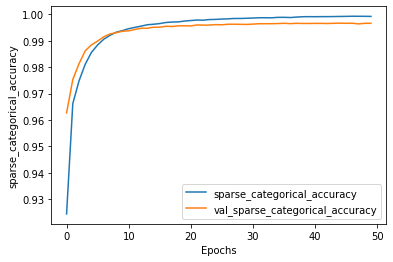

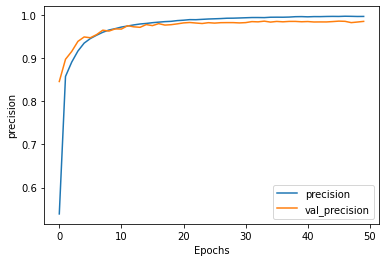

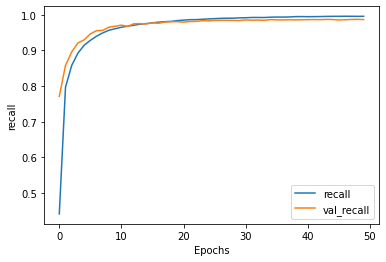

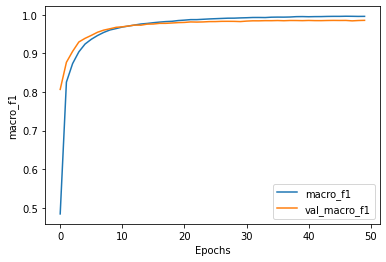

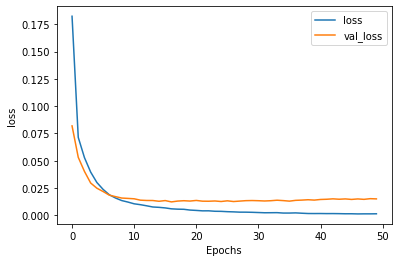

In [26]:
plot_graphs(model.history, 'sparse_categorical_accuracy')
plot_graphs(model.history, 'precision')
plot_graphs(model.history, 'recall')
plot_graphs(model.history, 'macro_f1')
plot_graphs(model.history, 'loss')

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [28]:
y_pred = []

pred = model.predict(X_te, batch_size=128) # fazendo a predição para as amostras de teste

for p in pred: # apenas transformando-as em um grande vetor de predições
    for word in p:
        y_pred.append(np.argmax(word))

In [29]:
y_pred = np.array(y_pred) # transformando em array
y_true = np.array([tag for word in y_te for tag in word]) # deixando uni dimensiona o vetor de classes verdadeiros

y_pred = y_pred[y_true != 0] # retirando do pred aquelas posições de padding
y_true = y_true[y_true != 0] # mesmo para as classes reais

conf_mat = confusion_matrix(y_true, np.array(y_pred)) # calculando a matriz de confusão

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fde12250da0&gt;

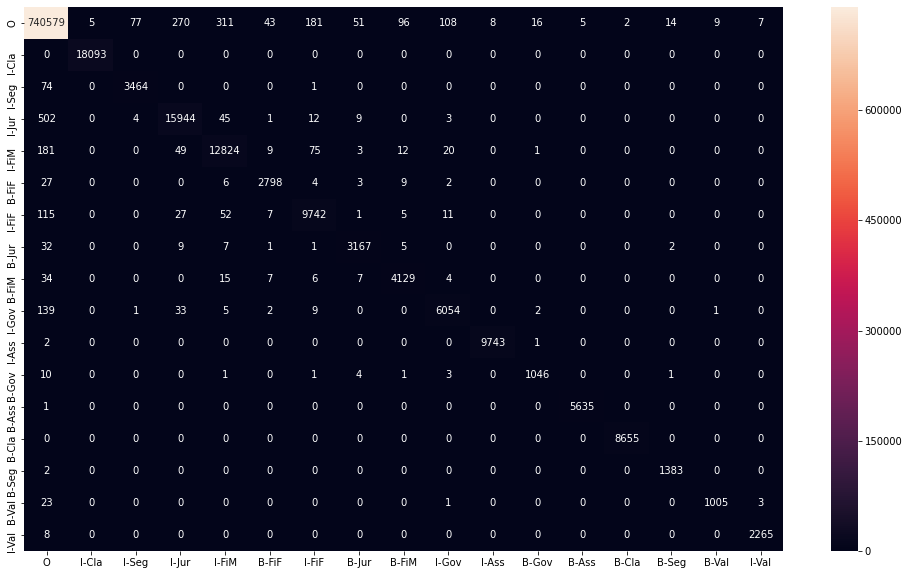

In [30]:
class_names = list(tag2idx.keys())
fig = plt.figure(figsize=(17,10))
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap

In [31]:
scores = classification_report(y_true, 
y_pred, target_names=class_names)
print(scores) 

              precision    recall  f1-score   support

           O       1.00      1.00      1.00    741782
       I-Cla       1.00      1.00      1.00     18093
       I-Seg       0.98      0.98      0.98      3539
       I-Jur       0.98      0.97      0.97     16520
       I-FiM       0.97      0.97      0.97     13174
       B-FiF       0.98      0.98      0.98      2849
       I-FiF       0.97      0.98      0.97      9960
       B-Jur       0.98      0.98      0.98      3224
       B-FiM       0.97      0.98      0.98      4202
       I-Gov       0.98      0.97      0.97      6246
       I-Ass       1.00      1.00      1.00      9746
       B-Gov       0.98      0.98      0.98      1067
       B-Ass       1.00      1.00      1.00      5636
       B-Cla       1.00      1.00      1.00      8655
       B-Seg       0.99      1.00      0.99      1385
       B-Val       0.99      0.97      0.98      1032
       I-Val       1.00      1.00      1.00      2273

    accuracy              